In [1]:
import sys
sys.path.append("../SpikeCounter")
from spikecounter.analysis import traces, images
from spikecounter import utils
from spikecounter.ui import visualize

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle
from datetime import datetime
import matplotlib.lines as mlines
import matplotlib.colors as colors
import seaborn as sns
import os
from scipy.io import savemat, loadmat
import skimage.io as skio
from skimage import transform, measure, feature, filters, draw, color, exposure, morphology
from skimage.util import img_as_ubyte
import colorcet as cc
from scipy import signal, stats, interpolate, optimize, ndimage
# plt.style.use(['science', 'notebook', 'no-latex'])
# mpl.rcParams['lines.linewidth']=1
plt.style.use("../bio_publications.mplstyle")

In [66]:
figdir = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat/Figures/v8"

In [3]:
os.makedirs(os.path.join(figdir, "Figure1", "SM1"), exist_ok=True)

In [67]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield/corrected"
fs=10.2
start_hpf = 19
expt_info = pd.read_csv(os.path.join(rootdir,"analysis/experiment_data.csv")).sort_values("start_time").reset_index()
start_times = [datetime.strptime(t,"%H:%M:%S") for t in list(expt_info["start_time"])]
offsets = [s - start_times[0] for s in start_times]
offsets = [o.seconds for o in offsets]
expt_info["offset"] = offsets
expt_info["hpf"] = start_hpf + expt_info["offset"]/3600

In [5]:
segmentation_mask = skio.imread(os.path.join(rootdir, "analysis/segmentation_video.tif"))
utils.display_zstack(segmentation_mask, c=0, pct_cutoffs=[0,100])
roi_map = np.median(segmentation_mask, axis=0)
roi_map = roi_map[np.arange(roi_map.shape[0], step=2),:]
roi_map = roi_map[:,np.arange(roi_map.shape[1], step=2)]

interactive(children=(IntSlider(value=59, description='z', max=118), Dropdown(description='c', options=('all',…

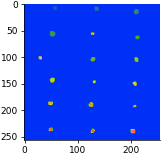

In [6]:
plt.imshow(roi_map)

In [7]:
file_idx = -20
remove_from_start = 15
remove_from_end=20
img = skio.imread(os.path.join(rootdir, "%s.tif" % expt_info["file_name"].iloc[file_idx]))
img = img[remove_from_start:img.shape[0]-remove_from_end,:,:]

In [8]:
mean_img = img.mean(axis=0)

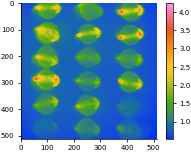

In [9]:
im = plt.imshow(mean_img)
plt.colorbar(im)

In [10]:
block_size = 375
local_thresh = filters.threshold_local(mean_img, block_size, offset=0)
embryo_mask = mean_img > local_thresh

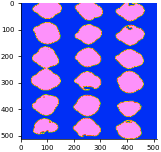

In [11]:
plt.imshow(embryo_mask)

### Generate cleaned up dFF image (ignoring background)

In [12]:
dFF_img = images.get_image_dFF(img)

In [13]:
dFF_img[:, ~embryo_mask] = np.nan

In [14]:
utils.display_zstack(dFF_img[600:800,:,:, np.newaxis], c=0, pct_cutoffs=[0,100])

interactive(children=(IntSlider(value=99, description='z', max=199), Dropdown(description='c', options=('all',…

In [19]:
skio.imsave(os.path.join(rootdir, "analysis", "demo_video_dFF.tif"), dFF_img[600:720])
skio.imsave(os.path.join(figdir, "Figure1/SM1", "demo_video_dFF.tif"), dFF_img[600:720])

In [20]:
skio.imsave(os.path.join(rootdir, "analysis", "demo_video_mean.tif"), np.tile(mean_img, (120,1,1)))
skio.imsave(os.path.join(figdir, "Figure1/SM1", "demo_video_mean.tif"), np.tile(mean_img, (120,1,1)))

In [ ]:
single_shot = n

### Calculate pixelwise pearson correlation

In [9]:
mask = segmentation_mask[file_idx,:,:]
mean_traces = []
for i in range(1, np.max(mask)+1):
    mean_traces.append(images.extract_mask_trace(img, mask==i))

In [24]:
ccors = []
for mt in mean_traces:
    ccor = np.apply_along_axis(lambda x: stats.pearsonr(x, mt), 0, img)
    ccors.append(ccor)
ccors = np.array(ccors)


In [25]:
ccors = ccors[:,0,:,:]

In [26]:
skio.imsave(os.path.join(rootdir, "analysis", "ccors.tif"), ccors)

In [33]:
ccors = skio.imread(os.path.join(rootdir, "analysis", "ccors.tif"))

### Draw correlation maps

In [14]:
mask[mask==18] = 0

In [15]:
segment_centroids = [k["centroid"] for k in measure.regionprops(mask)]

In [34]:
all_ccors = np.zeros_like(mean_img)
row_block_size = 512//6
col_block_size = 512//3
for idx, centroid in enumerate(segment_centroids):
    centroid_row, centroid_col = centroid
    row_min = int((centroid_row//row_block_size)*row_block_size)
    col_min = int((centroid_col//col_block_size)*col_block_size)
    row_max = int(min((centroid_row//row_block_size+1)*row_block_size,512))
    col_max = int(min((centroid_col//col_block_size+1)*col_block_size,512))
    all_ccors[row_min:row_max, col_min:col_max] = ccors[idx,row_min:row_max,col_min:col_max]

In [36]:
crop_top = 45
crop_bot = 30
mi_rot = np.rot90(mean_img)[crop_top:-crop_bot,:]
corr_rot = np.rot90(all_ccors)[crop_top:-crop_bot]
corr_rot[corr_rot < 0] = 0

In [46]:
cmap = plt.cm.get_cmap("cet_CET_L14")
cmap2 = plt.cm.get_cmap("cet_gray")

In [54]:
corr_rot_rgb = cmap(corr_rot)
mi_rgb = cmap2((mi_rot-np.min(mi_rot))/(np.max(mi_rot)-np.min(mi_rot)))

In [56]:
combined_img = np.minimum(mi_rgb + corr_rot_rgb, 1)

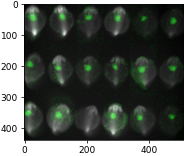

In [57]:
plt.imshow(combined_img)

55.5


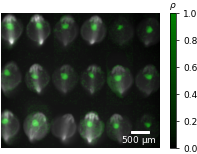

In [68]:
cmap = plt.cm.get_cmap("cet_CET_L14")
cmap2 = plt.cm.get_cmap("cet_gray")

crop_top = 45
crop_bot = 30
mi_rot = np.rot90(mean_img)[crop_top:-crop_bot,:]
corr_rot = np.rot90(all_ccors)[crop_top:-crop_bot]
corr_rot[corr_rot < 0] = 0

corr_rot_rgb = cmap(corr_rot)
mi_rgb = cmap2((mi_rot-np.min(mi_rot))/(np.max(mi_rot)-np.min(mi_rot)))
combined_img = np.minimum(mi_rgb + corr_rot_rgb, 1)

fig1, ax1 = plt.subplots(figsize=(3.3,2.4))
# fig1, ax1 = plt.subplots(figsize=(12,9))
ax1.imshow(combined_img)

bnorm = mpl.colors.BoundaryNorm(np.linspace(0,1,50), cmap.N)
clb = plt.colorbar(mpl.cm.ScalarMappable(norm=bnorm, cmap=cmap), \
                   ticks=np.linspace(-1,1,11))
# clb = plt.colorbar(corr_im, aspect=20, shrink=1, drawedges=False)
clb.ax.set_title(r"$\rho$",fontsize=9)
ax1.set_axis_off()
width_px = 500*111/1000
print(width_px)
rect = Rectangle((423,383), width_px, 5, color="white")
ax1.add_patch(rect)
ax1.text(390, 420, r"$500\ \mathrm{\mu m}$", fontsize=9, color="white")
plt.tight_layout()
plt.savefig(os.path.join(figdir, "Figure1", "correlations.tif"), dpi=600)
# plt.savefig(os.path.join("../all_widefield_data_new/segmentation.tif"), dpi=600)

In [ ]:
mi_rot_rescaled = exposure.rescale_intensity(mi_rot, out_range=(0,1))
mi_rot_rgb = plt.cm.get_cmap("cet_gray")(mi_rot_rescaled)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
corr_cmap = plt.cm.ScalarMappable(norm=norm, cmap="cet_CET_D2")

corr_rot_rgb = corr_cmap.to_rgba(corr_rot)
corr_rot_rgb[(corr_rot<window_transparent)*\
             (corr_rot > -window_transparent),3] = 0

mi_rot_alphad = np.array([np.multiply(mi_rot_rgb[:,:,3], mi_rot_rgb[:,:,i])\
                         for i in range(3)])

corr_rot_alphad = np.array([np.multiply(corr_rot_rgb[:,:,3], corr_rot_rgb[:,:,i])\
                         for i in range(3)])


merge_img = mi_rot_alphad + corr_rot_alphad*0.3
merge_img = np.moveaxis(merge_img, 0, 2)
merge_img = np.concatenate([merge_img, np.ones((merge_img.shape[0],\
                                              merge_img.shape[1],1))], axis=2)

merge_img = np.minimum(merge_img, np.ones_like(merge_img))
fig1, ax1 = plt.subplots(figsize=(3.3,2.4))
# ax1.imshow(mi_rot, cmap=plt.cm.get_cmap("cet_gray"))
# corr_im = ax1.imshow(corr_rot, cmap=plt.cm.get_cmap("cet_CET_D2"), alpha=0.3, vmin=-1, vmax=1)
ax1.imshow(merge_img)
# ax1.imshow(mi_rot_rgb)
cmap = plt.cm.get_cmap("cet_CET_D2")
bnorm = mpl.colors.BoundaryNorm(np.linspace(-1,1,50), cmap.N)
clb = plt.colorbar(mpl.cm.ScalarMappable(norm=bnorm, cmap=cmap), \
                   ticks=np.linspace(-1,1,11))
clb.ax.set_title(r"$\rho$",fontsize=9)
ax1.set_axis_off()
width_px = 500*111/1000
print(width_px)
rect = Rectangle((423,383), width_px, 5, color="white")
ax1.add_patch(rect)
ax1.text(400, 420, r"$500 \mathrm{\mu m}$", fontsize=9, color="white")
plt.tight_layout()
# plt.savefig(os.path.join("../all_widefield_data_new/segmentation_merge.tif"), dpi=600)

In [ ]:
embryo_rois = measure.label(embryo_mask)
plt.imshow(embryo_rois)

In [ ]:
segment_centroids = np.array(segment_centroids)

In [ ]:
embryo_centroids = np.array([k["centroid"] for k in measure.regionprops(embryo_rois)])
all_ccors = np.ones_like(mean_img)*np.nan
for idx in range(segment_centroids.shape[0]):
    dist = np.sum((segment_centroids[idx,:] - embryo_centroids)**2, axis=1)
    min_embryo = np.argmin(dist).ravel()[0]
    emask = embryo_rois == (min_embryo+1)
    all_ccors[emask] = ccors[idx,emask]

In [ ]:
crop_top = 45
crop_bot = 30
mi_rot = np.rot90(mean_img)[crop_top:-crop_bot,:]
corr_rot = np.rot90(all_ccors)[crop_top:-crop_bot]


fig1, ax1 = plt.subplots(figsize=(3.3,2.4))
ax1.imshow(mi_rot, cmap=plt.cm.get_cmap("cet_gray"))
corr_im = ax1.imshow(corr_rot, cmap=plt.cm.get_cmap("cet_CET_D2"), alpha=0.3, vmin=-1, vmax=1)
cmap = plt.cm.get_cmap("cet_CET_D2")
bnorm = mpl.colors.BoundaryNorm(np.linspace(-1,1,50), cmap.N)
clb = plt.colorbar(mpl.cm.ScalarMappable(norm=bnorm, cmap=cmap), \
                   ticks=np.linspace(-1,1,11))
# clb = plt.colorbar(corr_im, aspect=20, shrink=1, drawedges=False)
clb.ax.set_title(r"$\rho$",fontsize=9)
ax1.set_axis_off()
width_px = 500*111/1000
print(width_px)
rect = Rectangle((423,383), width_px, 5, color="white")
ax1.add_patch(rect)
ax1.text(400, 420, r"$500 \mathrm{\mu m}$", fontsize=9, color="white")
plt.tight_layout()
# plt.savefig(os.path.join("../all_widefield_data_new/segmentation_localthresh.tif"), dpi=600)

### How much of each embryo is spatially correlated with segmentation target

In [108]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield/corrected"
fs=10.2
start_hpf = 19
expt_info = pd.read_csv(os.path.join(rootdir,"analysis/experiment_data.csv")).sort_values("start_time").reset_index()
start_times = [datetime.strptime(t,"%H:%M:%S") for t in list(expt_info["start_time"])]
offsets = [s - start_times[0] for s in start_times]
offsets = [o.seconds for o in offsets]
expt_info["offset"] = offsets
expt_info["hpf"] = start_hpf + expt_info["offset"]/3600
with open(os.path.join(rootdir, "analysis", "usable_files.pickle"), "rb") as f:
    usable_files = pickle.load(f)
usable_indices = []
for fname in usable_files:
    contains_file = expt_info["file_name"].str.contains(fname).to_numpy()
    usable_indices.append(np.argwhere(contains_file).ravel()[0])
usable_indices = np.array(usable_indices)
expt_info = expt_info.iloc[usable_indices]

In [109]:
dFF_data = loadmat(os.path.join(rootdir, "analysis", "dFFs.mat"))

In [110]:
offset_times = dFF_data["offset_times"].ravel()
rois = dFF_data["rois"].ravel()

In [111]:
half_window = 1800
files_to_analyze = {}
timepoints = []
for idx, offset in enumerate(offset_times):
    first_idx = np.argwhere(expt_info["offset"].to_numpy()>(offset-half_window)).ravel()[0]-1
    if first_idx < 0:
        first_idx = 0
    last_idx = np.argwhere(expt_info["offset"].to_numpy()>(offset+half_window)).ravel()[0]
    if last_idx > expt_info.shape[0]:
        last_idx = expt_info.shape[0]
    
    files_to_analyze[rois[idx]] = expt_info["file_name"].iloc[first_idx:last_idx].to_numpy()
    timepoints.append(expt_info["offset"].iloc[first_idx:last_idx].to_numpy())
unique_files = sorted(list(set(np.concatenate(list(files_to_analyze.values())))))
unique_timepoints = sorted(list(set(np.concatenate(timepoints))))

In [112]:
correlation_data = {}
correlation_data["overlay_images"] = {}
correlation_data["correlations"] = {}
correlation_data["traces"] = {}
correlation_data["t_offsets"] = {}
correlation_data["segment_masks"] = {}
for roi in files_to_analyze.keys():
    correlation_data["overlay_images"][roi] = []
    correlation_data["correlations"][roi] = []
    correlation_data["traces"][roi] = []
    correlation_data["t_offsets"][roi] = []
    correlation_data["segment_masks"][roi] = []

In [113]:
bbox_offset=25
for idx, f in enumerate(unique_files):
    mask = skio.imread(os.path.join(rootdir, "analysis", "automasks", "%s_mask.tif" % f))
    mean_trace_data = pd.read_csv(os.path.join(rootdir, "analysis", "%s_traces.csv" % f)).set_index("region")
    
    bboxes = [p["bbox"] for p in measure.regionprops(mask)]
    rois_to_check = []
    
    for roi in files_to_analyze.keys():
        if f in files_to_analyze[roi]:
            rois_to_check.append(roi)
    print(f, rois_to_check)
    img = skio.imread(os.path.join(rootdir, "%s.tif" % f))[:-1]
    mean_img = img.mean(axis=0)
    for roi in rois_to_check:
        trace = mean_trace_data.loc[roi]["mean_intensity"].to_numpy()
        print(len(trace))
        bbox = bboxes[roi]
        print(bbox)
        r1 = max(bbox[0]-bbox_offset, 0)
        c1 = max(bbox[1]-bbox_offset, 0)
        r2 = min(bbox[2]+bbox_offset, mask.shape[0])
        c2 = min(bbox[3]+bbox_offset, mask.shape[1])
        cropped_img = img[:,r1:r2,c1:c2]
        print(cropped_img.shape)

        
        corrs = np.apply_along_axis(lambda x: stats.pearsonr(trace, \
                                                             x)[0], 0, cropped_img)
        correlation_data["correlations"][roi].append(corrs)
        correlation_data["overlay_images"][roi].append(mean_img[r1:r2,c1:c2])
        correlation_data["t_offsets"][roi].append(unique_timepoints[idx]-\
                                                  offset_times[np.argwhere(rois==roi).ravel()[0]])
        correlation_data["traces"][roi].append(trace)
        correlation_data["segment_masks"][roi].append(mask[r1:r2,c1:c2])
    with open(os.path.join(rootdir, "analysis", "correlation_data.pickle"), "wb") as data_file:
        pickle.dump(correlation_data, data_file)
    del img

073042_p1_t4_p1_z1 [4, 9]
1178
(106, 250, 119, 264)
(1178, 63, 64)
1178
(286, 258, 297, 273)
(1178, 61, 65)
073241_p1_t5_p1_z1 [4, 9]
1178
(106, 250, 119, 264)
(1178, 63, 64)
1178
(286, 258, 297, 273)
(1178, 61, 65)
073440_p1_t6_p1_z1 [4, 9]
1178
(106, 250, 119, 264)
(1178, 63, 64)
1178
(286, 258, 297, 273)
(1178, 61, 65)
073640_p1_t7_p1_z1 [4, 9]
1178
(106, 250, 119, 264)
(1178, 63, 64)
1178
(286, 258, 297, 273)
(1178, 61, 65)
073839_p1_t8_p1_z1 [4, 9]
1178
(106, 250, 119, 264)
(1178, 63, 64)
1178
(286, 258, 297, 273)
(1178, 61, 65)
074039_p1_t9_p1_z1 [4, 9]
1178
(106, 250, 119, 264)
(1178, 63, 64)
1178
(286, 258, 297, 273)
(1178, 61, 65)
074238_p1_t10_p1_z1 [4, 9]
1178
(106, 250, 119, 264)
(1178, 63, 64)
1178
(286, 258, 297, 273)
(1178, 61, 65)
074438_p1_t11_p1_z1 [4, 9]
1178
(106, 250, 119, 264)
(1178, 63, 64)
1178
(286, 258, 297, 273)
(1178, 61, 65)
074637_p1_t12_p1_z1 [4, 9]
1178
(106, 250, 119, 264)
(1178, 63, 64)
1178
(286, 258, 297, 273)
(1178, 61, 65)
074837_p1_t13_p1_z1 [4, 9

1178
(465, 248, 489, 266)
(1178, 72, 68)
1178
(468, 399, 488, 416)
(1178, 69, 67)
1178
(462, 90, 481, 109)
(1178, 69, 69)
1178
(378, 406, 390, 421)
(1178, 62, 65)
082428_p1_t31_p1_z1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
1178
(5, 111, 18, 124)
(1178, 43, 63)
1178
(8, 264, 24, 283)
(1178, 49, 69)
1178
(18, 414, 38, 432)
(1178, 63, 68)
1178
(111, 95, 125, 113)
(1178, 64, 68)
1178
(106, 251, 119, 264)
(1178, 63, 63)
1178
(112, 416, 132, 434)
(1178, 70, 68)
1178
(199, 246, 221, 267)
(1178, 72, 71)
1178
(199, 416, 220, 433)
(1178, 71, 67)
1178
(277, 95, 299, 115)
(1178, 72, 70)
1178
(290, 406, 302, 422)
(1178, 62, 66)
1178
(363, 90, 381, 110)
(1178, 68, 70)
1178
(370, 242, 389, 260)
(1178, 69, 68)
1178
(465, 248, 489, 266)
(1178, 72, 68)
1178
(468, 399, 488, 416)
(1178, 69, 67)
1178
(462, 90, 481, 109)
(1178, 69, 69)
1178
(378, 406, 390, 421)
(1178, 62, 65)
082627_p1_t32_p1_z1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
1178
(5, 111, 18, 124)
(1178, 43, 63)
117

1178
(363, 90, 381, 110)
(1178, 68, 70)
1178
(368, 241, 390, 262)
(1178, 72, 71)
1178
(465, 248, 489, 266)
(1178, 72, 68)
1178
(468, 399, 488, 416)
(1178, 69, 67)
1178
(463, 90, 484, 109)
(1178, 71, 69)
1178
(376, 405, 392, 423)
(1178, 66, 68)
084821_p1_t43_p1_z1 [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
1178
(6, 108, 26, 125)
(1178, 51, 67)
1178
(8, 263, 28, 281)
(1178, 53, 68)
1178
(16, 412, 39, 432)
(1178, 64, 70)
1178
(111, 95, 125, 113)
(1178, 64, 68)
1178
(116, 417, 128, 433)
(1178, 62, 66)
1178
(198, 246, 221, 267)
(1178, 73, 71)
1178
(199, 416, 220, 433)
(1178, 71, 67)
1178
(277, 95, 299, 115)
(1178, 72, 70)
1178
(291, 409, 310, 424)
(1178, 69, 65)
1178
(363, 90, 381, 110)
(1178, 68, 70)
1178
(369, 241, 389, 261)
(1178, 70, 70)
1178
(474, 248, 489, 260)
(1178, 63, 62)
1178
(468, 399, 488, 416)
(1178, 69, 67)
1178
(463, 89, 484, 109)
(1178, 71, 70)
1178
(375, 404, 392, 422)
(1178, 67, 68)
085021_p1_t44_p1_z1 [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16]
1178
(6

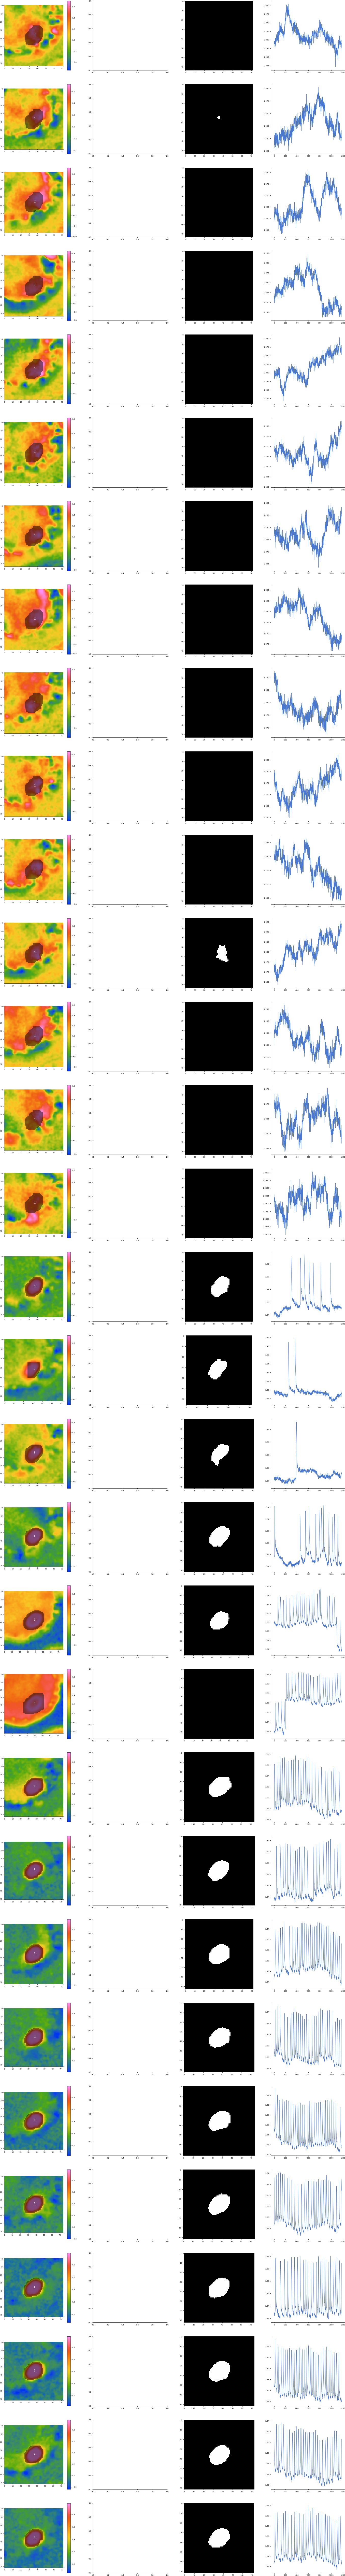

In [24]:
%matplotlib inline
for expt in ["20210420_gcamp_widefield", "20210716_gcamp_widefield",
            "20210724_gcamp_widefield"][:1]:
    rootdir = "/n/holyscratch01/cohen_lab/bjia/%s/corrected" % expt
    with open(os.path.join(rootdir, "analysis", "correlation_data.pickle"), "rb") as data_file:
        correlation_data = pickle.load(data_file)
    plt.close("all")
    correlation_data["correlated_size"] = {}
    correlation_data["mean_corr"] = {}
    for roi in list(correlation_data["traces"].keys())[2:3]:
        correlation_data["mean_corr"][roi] = []
        correlation_data["correlated_size"][roi] = []
        roi_overlay_images = correlation_data["overlay_images"][roi]
        roi_correlations = correlation_data["correlations"][roi]
        roi_masks = correlation_data["segment_masks"][roi]
        roi_traces = correlation_data["traces"][roi]
        fig1, axes = plt.subplots(len(roi_correlations), 4, figsize=(24, 6*len(roi_overlay_images)))
        for i in range(len(roi_correlations)):
            roi_mask = roi_masks[i]

            fig, ax, plotimg, mask_im = visualize.display_roi_overlay(roi_correlations[i], roi_mask==(roi+1),\
                                            ax=axes[i,0], cmap="cet_CET_R1", mask_cmap="gray")
            plt.colorbar(plotimg, ax=axes[i,0])
            
            local = roi_correlations[i] > filters.threshold_local(roi_correlations[i], 35,\
                                                offset=-0.15)

            filled = measure.label(ndimage.binary_fill_holes(local))
            centroid_roi = measure.regionprops(roi_mask)[0]["centroid"]
            if filled[int(centroid_roi[0]), int(centroid_roi[1])] > 0:
                filled = filled == filled[int(centroid_roi[0]), int(centroid_roi[1])]
#                 for j in range(2):
#                     filled = morphology.binary_erosion(filled, footprint=morphology.disk(1))
#                 if np.median(roi_correlations[i][filled]) < 0.7:
#                     filled[:] = 0
            else:
                filled[:] = 0
            axes[i,2].imshow(filled, cmap="gray")
            axes[i,3].plot(roi_traces[i])

            area = np.sum(filled)
            if area > 0:
                mean_corr = np.sum(roi_correlations[i][filled])/area
            else:
                mean_corr = 0
            correlation_data["correlated_size"][roi].append(area)
            correlation_data["mean_corr"][roi].append(mean_corr)

In [25]:
for expt in ["20210420_gcamp_widefield", "20210716_gcamp_widefield",
            "20210724_gcamp_widefield"]:
    rootdir = "/n/holyscratch01/cohen_lab/bjia/%s/corrected" % expt
    with open(os.path.join(rootdir, "analysis", "correlation_data.pickle"), "rb") as data_file:
        correlation_data = pickle.load(data_file)
    plt.close("all")
    %matplotlib agg
    correlation_data["correlated_size"] = {}
    correlation_data["mean_corr"] = {}
    for roi in correlation_data["traces"].keys():
        correlation_data["mean_corr"][roi] = []
        correlation_data["correlated_size"][roi] = []
        roi_overlay_images = correlation_data["overlay_images"][roi]
        roi_correlations = correlation_data["correlations"][roi]
        roi_masks = correlation_data["segment_masks"][roi]
        roi_traces = correlation_data["traces"][roi]
        fig1, axes = plt.subplots(len(roi_correlations), 4, figsize=(24, 6*len(roi_overlay_images)))
        for i in range(len(roi_correlations)):
            roi_mask = roi_masks[i]

            fig, ax, plotimg, mask_im = visualize.display_roi_overlay(roi_correlations[i], roi_mask==(roi+1),\
                                            ax=axes[i,0], cmap="cet_CET_R1", mask_cmap="gray")
            plt.colorbar(plotimg, ax=axes[i,0])
            local = roi_correlations[i] > filters.threshold_local(roi_correlations[i], 35,\
                                                offset=-0.15)

            filled = measure.label(ndimage.binary_fill_holes(local))
            centroid_roi = measure.regionprops(roi_mask)[0]["centroid"]
            if filled[int(centroid_roi[0]), int(centroid_roi[1])] > 0:
                filled = filled == filled[int(centroid_roi[0]), int(centroid_roi[1])]
#                 for j in range(2):
#                     filled = morphology.binary_erosion(filled, footprint=morphology.disk(1))
#                 if np.median(roi_correlations[i][filled]) < 0.7:
#                     filled[:] = 0
            else:
                filled[:] = 0
            axes[i,2].imshow(filled, cmap="gray")
            axes[i,3].plot(roi_traces[i])

            area = np.sum(filled)
            if area > 0:
                mean_corr = np.sum(roi_correlations[i][filled])/area
            else:
                mean_corr = 0
            correlation_data["correlated_size"][roi].append(area)
            correlation_data["mean_corr"][roi].append(mean_corr)
        plt.savefig(os.path.join(rootdir, "analysis", "E%d_correlations.tif" % roi), dpi=150)
        with open(os.path.join(rootdir, "analysis", "correlation_data.pickle"), "wb") as data_file:
            pickle.dump(correlation_data, data_file)

In [ ]:

for roi in list(correlation_data["correlated_size"].keys()):
    fig1, ax1 = plt.subplots(figsize=(6,4))
    y = correlation_data["correlated_size"][roi]/np.percentile(correlation_data["correlated_size"][roi], 95)
    x = np.arange(len(y))
#     print(len(y))
    ax1.scatter(x, y)
    ax1.s